# <center> Recommender Systems
## <center> Collaborative Filtering; Content Based; Hybrid System
    
Here in this notebook, we would like to create a recommender system based on dataset found here.
    
    Author: Tri Juliansyah Muharam Sambas; Rangga Pratama
    Date: 15th November 2019

## Outline
- TLDR; Executive Summary
- Importing Libraries
- Importing Dataset
- Exploratory Data Analysis
- Modeling
- Simulation

## TLDR; Executive Summary

## Import Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Words visualization
from wordcloud import WordCloud

# Machine learning
from sklearn.cluster import KMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

# Others
from collections import Counter
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
# importing rating from github
rating_source = 'https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/ratings.csv'
df = pd.read_csv(rating_source)

# deleting unneeded column
del df['timestamp']

# importing title from github
title_source = 'https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/movies.csv'
title = pd.read_csv(title_source)

# merging dataset with title
df = pd.merge(df, title, on = 'movieId', how = 'left')

# importing tags from github
tags = pd.read_csv('https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/tags.csv')

# deleting uneeded column
del tags['timestamp']

# merging dataset with tags
df = pd.merge(df, tags, on = ['movieId','userId'], how = 'left')

In [3]:
df.head(3)

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,NaN
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,NaN


In [87]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

print('The number of users: ' + str(n_users))
print('The number of movie: ' + str(n_movies))

The number of users: 610
The number of movie: 9724


### Data Preprocessing

#### Data Cleaning

In [5]:
year = []
title = []
title_df = list(df['title'])
for i in range(len(title_df)) :
    if title_df[i][-2].isdigit() == True :
        year.append(title_df[i][-5:-1])
        title.append(title_df[i][:-6])
    else :
        year.append('NaN')
        title.append(title_df[i])
        
df['title'] = title
df['year'] = year

#### New Encoding (For Collaborative Filtering)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
encoder = LabelEncoder()

In [8]:
df['movieId_new'] = encoder.fit_transform(df['movieId'])
df['userId_new'] = encoder.fit_transform(df['userId'])

In [9]:
# creating a movie list
movie_list = df[['movieId_new','title']].drop_duplicates().sort_values(by = 'movieId_new').set_index('movieId_new')

## Exploratory Data Analysis

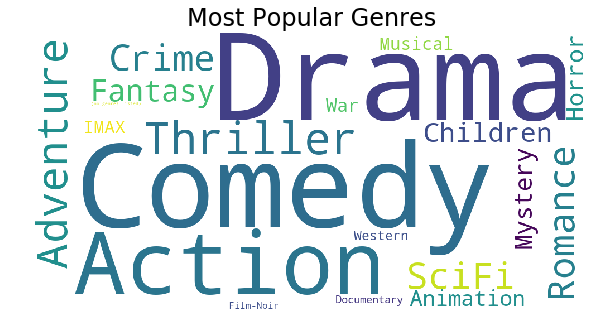

In [10]:
# creating wordcloud of the most popular genres
plt.figure(figsize = (10,10))
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 500, max_words = 100).generate_from_frequencies(Counter(','.join(df['genres'].str.replace('|',',')).replace('Sci-Fi','SciFi').split(',')))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Genres',fontsize = 24)
plt.show()

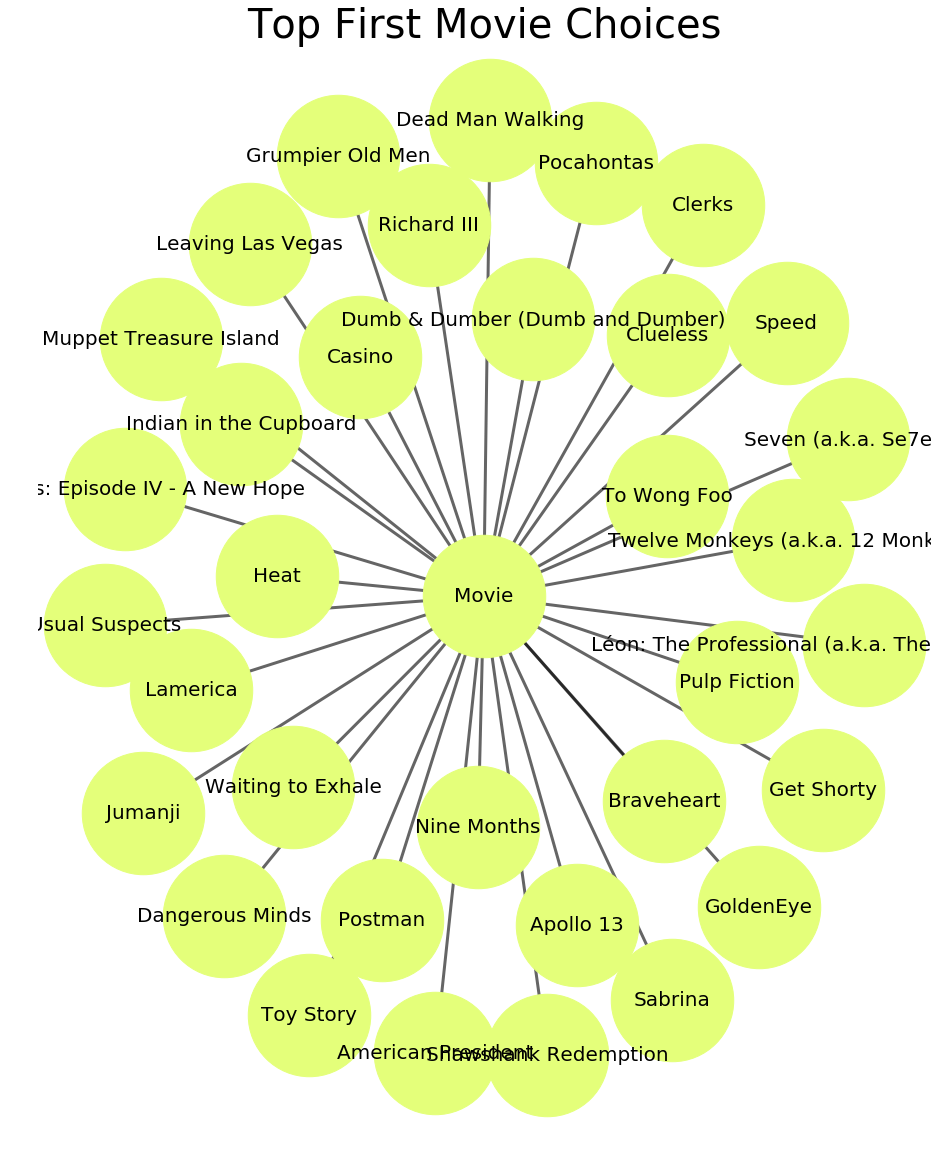

In [11]:
# listing top first movie to watch
df_nx = pd.DataFrame(df['userId'].unique()).rename(columns = {0 : 'userId'})
df['title'] = df['title'].str.rstrip()
listuser = list(df_nx['userId'])
listtitle = []
for i in range(len(listuser)) :
    title = ', '.join(df[df['userId'] == listuser[i]]['title'])
    listtitle.append(title)
df_nx['title'] = listtitle
del df_nx['userId']

df_nx = df_nx['title'].str.split(',', expand = True)

df_nx['movie'] = 'Movie'
movie = df_nx.truncate(before = -1, after = 100)

movie = nx.from_pandas_edgelist(movie, source = 'movie', target = 0, edge_attr = True)

plt.rcParams['figure.figsize'] = (16, 20)
pos = nx.spring_layout(movie)
color = plt.cm.Wistia(np.linspace(0, 5, 1))
nx.draw_networkx_nodes(movie, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(movie, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(movie, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top First Movie Choices', fontsize = 40)
plt.show()

Text(0.5, 1.0, 'Minimum Support 0.3')

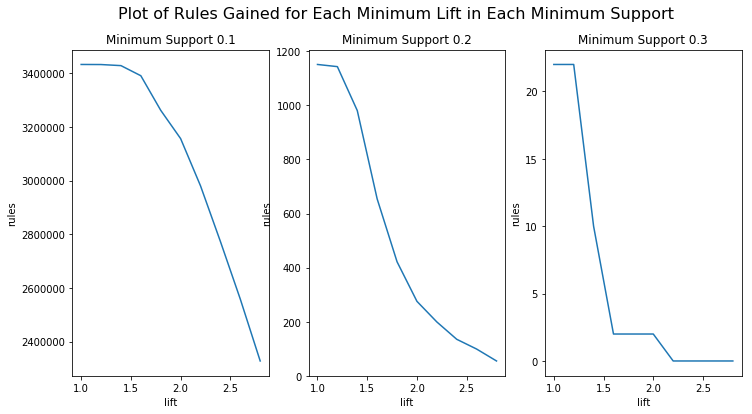

In [12]:
# plotting rules gained for each minimum lift and each minimum support to find the most optimal point
movielist = []
for i in df['userId'].unique() :
    mlist = list(set(df[df['userId'] == i]['title']))
    if len(mlist) > 0 :
        movielist.append(mlist)

te = TransactionEncoder()
te_ary = te.fit(movielist).transform(movielist)
df_apriori = pd.DataFrame(te_ary, columns = te.columns_)

list_supp = [0.1,0.2,0.3]
list_lift = [1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8]
rules_each_lift = []
for i in list_supp : 
    frequent_moviesets = apriori(df_apriori, min_support = i)
    for j in list_lift :
        rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = j)
        rules_each_lift.append(len(rules))

rules_each_lift = [rules_each_lift[i:i + 10] for i in range(0, len(rules_each_lift), 10)]
rules_a = rules_each_lift[0]
rules_b = rules_each_lift[1]
rules_c = rules_each_lift[2]

plt.figure(figsize = (12,6))
plt.suptitle('Plot of Rules Gained for Each Minimum Lift in Each Minimum Support', size = 16)

plt.subplot(1,3,1)
a = sns.lineplot(x=list_lift, y = rules_a)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.1')

plt.subplot(1,3,2)
b = sns.lineplot(x=list_lift, y = rules_b)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.2')

plt.subplot(1,3,3)
c = sns.lineplot(x=list_lift, y = rules_c)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.3')

## Modeling

### Dataset Splitting

#### Splitting

In [13]:
from sklearn.model_selection import train_test_split

In [84]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state = 42)

In [85]:
print('Your train shape is: %i x %i' %train_data.shape)
print('Your test shape is: %i x %i' %test_data.shape)

Your train shape is: 77007 x 9
Your test shape is: 25670 x 9


#### Rating Matrices

In [88]:
# Create two user-item matrices, one for training and another for testing
# Matrix[new_user,new_movie] = rating
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[-1]-1, line[-2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[-1]-1, line[-2]-1] = line[3]

In [89]:
print('Your train data matrix is: %i x %i' %train_data_matrix.shape)
print('Your test data matrix is: %i x %i' %test_data_matrix.shape)

Your train data matrix is: 610 x 9724
Your test data matrix is: 610 x 9724


In [90]:
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 4., 0., ..., 0., 0., 4.]])

### Apriori

In [19]:
# from the EDA above, we choose min_support = 0.1 and min_threshold 1.6 as the optimal point
frequent_moviesets = apriori(df_apriori, min_support = 0.1, use_colnames = True)
rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = 1.6)
rules.sort_values('confidence', ascending = False) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1695750,"(Die Hard, Star Wars: Episode VI - Return of t...","(Matrix, The, Star Wars: Episode IV - A New Hope)",0.103279,0.300000,0.103279,1.00000,3.333333,0.072295,inf
1944719,"(Matrix, The, Die Hard, Star Wars: Episode VI ...",(Star Wars: Episode V - The Empire Strikes Back),0.114754,0.345902,0.114754,1.00000,2.890995,0.075060,inf
2823162,"(Sixth Sense, The, Lord of the Rings: The Fell...","(Lord of the Rings: The Return of the King, The)",0.101639,0.303279,0.101639,1.00000,3.297297,0.070814,inf
2451429,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope),0.101639,0.411475,0.101639,1.00000,2.430279,0.059817,inf
1118454,"(Kill Bill: Vol. 2, Pulp Fiction, Fight Club, ...",(Kill Bill: Vol. 1),0.100000,0.214754,0.100000,1.00000,4.656489,0.078525,inf
...,...,...,...,...,...,...,...,...,...
2857281,(Forrest Gump),"(Toy Story, Star Wars: Episode V - The Empire ...",0.539344,0.101639,0.100000,0.18541,1.824198,0.045181,1.102838
1049785,(Forrest Gump),"(Godfather, The, Silence of the Lambs, The, Fi...",0.539344,0.109836,0.100000,0.18541,1.688064,0.040761,1.092776
2857155,(Forrest Gump),(Star Wars: Episode V - The Empire Strikes Bac...,0.539344,0.104918,0.100000,0.18541,1.767192,0.043413,1.098813
1049815,(Forrest Gump),"(Sixth Sense, The, Godfather, The, Star Wars: ...",0.539344,0.108197,0.100000,0.18541,1.713641,0.041645,1.094788


#### Simulation of Recommendation by Apriori Algorithm

In [20]:
# creating "basket" of movies given a movie title (so we can recommend another movies to watch after a certain movie)
watched = 'Toy Story '   # INPUT THE TITLE AND GIVE SPACE IN THE END

dum = rules[rules['consequents'] == frozenset({watched})].sort_values(by = 'lift', ascending = False).head(5)
dum['len'] = len(dum['antecedents'])

for x in dum.sort_values(by = 'len').head(1)['antecedents'].apply(lambda x : list(x)).astype('unicode'):
    print(x)

So after a person watch Toy Story, based on the apriori algorithm, it's better to recommend him Jurassic Park, Pulp Fiction, Indiana Jones and the Last Crusade, Back to the Future, Star Wars : Episode IV - A New Hope

### Collaborative Filtering

#### Non-Probabilistic

##### Similarity Function

In [21]:
from sklearn.metrics.pairwise import pairwise_distances

In [91]:
train_similarity = pairwise_distances(train_data_matrix, metric='cosine')
print('Your train similarity matrix shape is: %i x %i' %train_similarity.shape)

Your train similarity matrix shape is: 610 x 610


In [92]:
test_similarity = pairwise_distances(test_data_matrix, metric='cosine')
print('Your test similarity matrix shape is: %i x %i' %test_similarity.shape)

Your test similarity matrix shape is: 610 x 610


##### User-Based

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

In [93]:
def user_based_prediction(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    #You use np.newaxis so that mean_user_rating has same format as ratings
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

In [94]:
prediction = user_based_prediction(train_data_matrix, train_similarity)

##### Model Evaluation

In [95]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [96]:
print('User-based CF RMSE: ' + str(rmse(prediction, test_data_matrix)))

User-based CF RMSE: 3.308396171594543


##### Item-Based

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

##### Similarity Function

In [97]:
train_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
print('Your train similarity matrix shape is: %i x %i' %train_similarity.shape)

Your train similarity matrix shape is: 9724 x 9724


In [98]:
test_similarity = pairwise_distances(test_data_matrix.T, metric='cosine')
print('Your test similarity matrix shape is: %i x %i' %test_similarity.shape)

Your test similarity matrix shape is: 9724 x 9724


In [99]:
def item_based_prediction(ratings, similarity):
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)]) 
    return pred

In [100]:
prediction = item_based_prediction(train_data_matrix, train_similarity)

##### Model Evaluation

In [101]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [102]:
print('Item-based CF RMSE: ' + str(rmse(prediction, test_data_matrix)))

Item-based CF RMSE: 3.5272727600253333


#### Singular Value Decomposition

In [103]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE (using SVD): ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE (using SVD): 3.05732486922338


#### Simulation on Collaborative Filtering

In [163]:
from ipywidgets import interact

@interact
def cf_suggestion(user=df['userId'].unique(), pred_method = ['user','item','svd'], num_to_suggest = 10):
    # Create two user-item matrices, one for training and another for testing
    # Matrix[new_user_id,new_movie_id] = rating
    n_users = df['userId'].nunique()
    n_movies = df['movieId'].nunique()
    data_matrix = np.zeros((n_users, n_movies))
    for line in df.itertuples():
        data_matrix[line[-1]-1, line[-2]-1] = line[3]
    
    # ratings calculation
    if pred_method == 'user': # user-based
        similarity_matrix = pairwise_distances(data_matrix, metric='cosine')
        prediction_matrix = user_based_prediction(data_matrix, similarity_matrix)
    elif pred_method == 'item': # item-based
        similarity_matrix = pairwise_distances(data_matrix.T, metric='cosine')
        prediction_matrix = item_based_prediction(data_matrix, similarity_matrix)
    elif pred_method == 'svd': # svd
        u, s, vt = svds(data_matrix, k = 20)
        s_diag_matrix = np.diag(s)
        prediction_matrix = np.dot(np.dot(u, s_diag_matrix), vt)
    
    # rating for all movies by the user
    ranks_from_user = prediction_matrix[user - 1,:]
    
    # creating movie list
    pred_movie_list = movie_list.copy()
    pred_movie_list['real_review'] = data_matrix[user - 1,:]
    pred_movie_list['pred_review'] = ranks_from_user
    
    # sorting predicted movie list
    pred_movie_list.sort_values(by = 'pred_review', ascending = False, inplace=True)
    pred_movie_list.reset_index(inplace = True)
    
    # listed 10 not yet reviewed movies
    to_suggest = pred_movie_list.loc[pred_movie_list['real_review'] == 0,'title'][:num_to_suggest].values
    print('Your movie top %i suggestions are: \n' %num_to_suggest)
    for movie in to_suggest:
        print(movie)
        
    return to_suggest

interactive(children=(Dropdown(description='user', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### Content-Based

#### Data Preparation

In [36]:
# preparing data for content based

movie_data = pd.read_csv('D:/Titip/movie_metadata.csv')

movie_data.drop(['director_name','actor_2_name','genres','actor_1_name','actor_3_name','movie_imdb_link','title_year','plot_keywords'], axis = 1, inplace = True)
movie_data.dropna(axis = 0, inplace = True)
movie_data['movie_title'] = movie_data['movie_title'].str.strip()

In [37]:
df_content_based = df.copy()
df_content_based = df_content_based.rename(columns = {'title' : 'movie_title'})
df_content_based['genres'] = df_content_based['genres'].str.replace('|',' ')
df_content_based['genres'] = df_content_based['genres'].str.split(' ').str.get(0)
del df_content_based['tag']
df_content_based = pd.merge(df_content_based,movie_data, on = 'movie_title', how = 'left').dropna(axis = 0)
df_content_based.drop_duplicates(subset = ['userId','movieId','rating'], inplace = True)
df_content_based['year'] = df_content_based['year'].astype(str)
df_content_based = pd.get_dummies(df_content_based, columns = ['genres','color','language','country','content_rating'])

In [38]:
df_content_based.head(3)

,userId,movieId,rating,movie_title,year,movieId_new,userId_new,num_critic_for_reviews,duration,director_facebook_likes,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,1,1,4.0,Toy Story,1995,0,0,166.0,74.0,487.0,...,0,0,0,0,0,0,0,0,0,0
5,1,70,3.0,From Dusk Till Dawn,1996,62,0,165.0,108.0,0.0,...,0,0,0,0,0,0,0,1,0,0
6,1,101,5.0,Bottle Rocket,1996,89,0,83.0,91.0,0.0,...,0,0,0,0,0,0,0,1,0,0


#### K-Means Clustering

In [39]:
# input userId
userId = 1

In [40]:
# list of movie_title watched by userId
col = [col for col in df_content_based.columns if col not in ['userId','movieId','movie_title','year']]
user_movie = df_content_based[df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col]

In [41]:
# list of mean of all content (numerical characteristic of the movie watched by the user)
user_movie_mean = pd.DataFrame(user_movie.mean().to_dict(), index = [user_movie.index.values[-1]])

In [42]:
# getting another movie not yet watched by the userId
col2 = [col for col in df_content_based.columns if col not in ['userId','movieId','year']]
user_not_watched = user_movie = df_content_based[~df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col2]

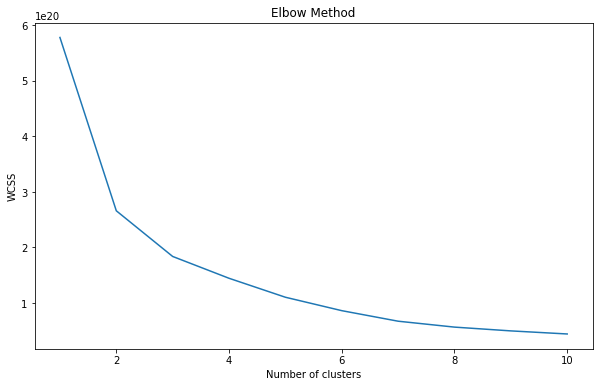

In [43]:
# checking the best number of clusters based on content of unwatched movie
plt.figure(figsize = (10,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [44]:
# choose 6 clusters
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(6)
user_not_watched['cluster'] = pd.DataFrame(lut[kmeans.labels_])
user_not_watched.dropna(axis = 0,inplace = True)
user_not_watched['cluster'] = user_not_watched['cluster'].astype(int)

#### Simulation on Content-Based Filtering

In [54]:
# fitting the clustering to the movie watched by userId and get all movie in the unwatched movie which match with the cluster

to_recommend = user_not_watched[user_not_watched['cluster'] == kmeans.predict(user_movie_mean)[0]]

In [55]:
to_recommend

,rating,movie_title,movieId_new,userId_new,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,...,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X,cluster
300,0.5,Requiem for a Dream,2941,2,234.0,102.0,0.0,167.0,1000.0,3609278.0,...,0,0,0,0,0,0,1,0,0,3
331,3.0,Heavenly Creatures,211,3,93.0,108.0,0.0,88.0,14000.0,3049135.0,...,0,0,0,0,0,0,1,0,0,3
471,5.0,Hairspray,2200,3,219.0,117.0,163.0,260.0,719.0,118823091.0,...,0,0,0,1,0,0,0,0,0,3
514,2.0,Memento,3136,3,274.0,113.0,22000.0,379.0,716.0,25530884.0,...,0,0,0,0,0,0,1,0,0,3
538,3.0,Apollo 13,123,4,159.0,140.0,2000.0,552.0,15000.0,172071312.0,...,0,0,0,1,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40485,2.5,2001: A Space Odyssey,706,273,285.0,161.0,0.0,73.0,273.0,56715371.0,...,0,0,0,0,0,0,0,0,0,3
40552,4.0,Butch Cassidy and the Sundance Kid,1001,273,130.0,110.0,131.0,399.0,640.0,102308900.0,...,1,0,0,0,0,0,0,0,0,3
40557,3.5,Carrie,1032,273,359.0,100.0,108.0,534.0,17000.0,35266619.0,...,0,0,0,0,0,0,1,0,0,3
40563,3.5,Die Hard 2,1052,273,142.0,124.0,212.0,576.0,13000.0,117541000.0,...,0,0,0,0,0,0,1,0,0,3


In [56]:
# choosing only 5 movies with closest Euclidian Distance to user_movie_mean
def Euclidean_Dist(to_recommend, user_movie_mean, cols=[col for col in to_recommend.columns if col not in ['cluster','movie_title']]):
    return np.linalg.norm(to_recommend[cols].values - user_movie_mean[cols].values,
                   axis=1)
to_recommend['dist'] = Euclidean_Dist(to_recommend, pd.concat([user_movie_mean]*len(to_recommend), ignore_index = True))

for x in list(to_recommend.sort_values(by = 'dist')['movie_title'].unique()[0:5]) :
    print(x)

Lethal Weapon 3
Rambo: First Blood Part II
Gran Torino
Cheaper by the Dozen
21 Jump Street


### Hybrid

#### Simulation on Hybrid Method

In [116]:
# listing all the movie from content based method and preparing the data for creating the matrix for collaboration filtering

to_recommend = user_not_watched[user_not_watched['cluster'] == kmeans.predict(user_movie_mean)[0]]
to_recommend['dist'] = Euclidean_Dist(to_recommend, pd.concat([user_movie_mean]*len(to_recommend), ignore_index = True))
list_movie_content = list(to_recommend.sort_values(by = 'dist')['movie_title'].unique())

In [164]:
to_suggest = cf_suggestion(1,'user',100)

Your movie top 100 suggestions are: 

Flintstones, The 
Pyromaniac's Love Story, A 
Batman 
Walk on the Moon, A 
Kiss of Death 
Catwalk 
Savage Nights (Nuits fauves, Les) 
Judgment Night 
Someone to Watch Over Me 
Aladdin 
Cheech and Chong's Up in Smoke 
When Night Is Falling 
Andrew Dice Clay: Dice Rules 
Princess Bride, The 
Yellow Submarine 
Once Upon a Time in the West (C'era una volta il West) 
Tin Cup 
How to Make an American Quilt 
Kate & Leopold 
Amateur 
Fresh 
Jane Austen's Mafia! 
Candyman: Farewell to the Flesh 
Morvern Callar 
Girl with a Pearl Earring 
Dangerous Minds 
'Til There Was You 
Ghost 
Arsenic and Old Lace 
Iron Giant, The 
Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) 
Dances with Wolves 
Angel Eyes 
Terminator 2: Judgment Day 
Timecop 
Dish, The 
River Wild, The 
Star Wars: Episode V - The Empire Strikes Back 
Courage Under Fire 
Goodfellas 
Fall 
Some Kind of Wonderful 
Private Benjamin 
Diva 
Snow White and the S

In [174]:
to_suggest = list(to_suggest)
to_suggest = [x.strip() for x in to_suggest]

In [181]:
print('Your movie suggestions based on Hybrid Method are: ')

for x in to_suggest :
    if x in list_movie_content :
        print(x)

Your movie suggestions based on Hybrid Method are: 
Aladdin
Tin Cup
Ghost
Terminator 2: Judgment Day
Timecop
Courage Under Fire
Snow White and the Seven Dwarfs
Outbreak
Vampires
Brazil
Lake Placid
Deuce Bigalow: Male Gigolo
Unbreakable
